In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import datetime as dt

## Step 1 - Gathering and Exploring Data

Let us first download the data for 3 ETFs. I am downloading data for the years starting 2012 and until 2022. Of these, the data from 2018 to 2022 will be used for testing.

In [4]:
equity = yf.Ticker("SPY").history(start="2012-01-01", end="2022-12-31")
crude_oil = yf.Ticker("DBO").history(start="2012-01-01", end="2022-12-31")
gold = yf.Ticker("GLD").history(start="2012-01-01", end="2022-12-31")

#extract only the date from the date timestamp
#equity.index = equity.index.date
#crude_oil.index = crude_oil.index.date
#gold.index = gold.index.date

In [5]:
equity.head() #first look at the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2012-01-03 00:00:00-05:00,100.958312,101.448249,100.697538,100.752853,193697900,0.0,0.0,0.0
2012-01-04 00:00:00-05:00,100.515764,100.997798,100.128559,100.910873,127186500,0.0,0.0,0.0
2012-01-05 00:00:00-05:00,100.365632,101.329694,99.907304,101.179550,173895000,0.0,0.0,0.0
2012-01-06 00:00:00-05:00,101.306013,101.321821,100.586918,100.918808,148050000,0.0,0.0,0.0
2012-01-09 00:00:00-05:00,101.147988,101.290221,100.681762,101.163795,99530200,0.0,0.0,0.0


In [6]:
crude_oil.head() #fist look at the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2012-01-03 00:00:00-05:00,25.796449,26.094877,25.770118,26.042213,318300,0.0,0.0,0.0
2012-01-04 00:00:00-05:00,25.954440,26.235313,25.884221,26.165094,422800,0.0,0.0,0.0
2012-01-05 00:00:00-05:00,26.015878,26.244088,25.796446,25.814001,249700,0.0,0.0,0.0
2012-01-06 00:00:00-05:00,26.015880,26.015880,25.673566,25.919331,357900,0.0,0.0,0.0
2012-01-09 00:00:00-05:00,25.849115,25.875446,25.550687,25.831560,213900,0.0,0.0,0.0


In [7]:
gold.head() #first look at the gold data etf

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2012-01-03 00:00:00-05:00,154.759995,156.300003,154.550003,155.919998,13385800,0.0,0.0,0.0
2012-01-04 00:00:00-05:00,155.429993,157.380005,155.339996,156.710007,11549700,0.0,0.0,0.0
2012-01-05 00:00:00-05:00,155.369995,158.029999,155.250000,157.779999,11621600,0.0,0.0,0.0
2012-01-06 00:00:00-05:00,158.589996,158.630005,156.380005,157.199997,9790500,0.0,0.0,0.0
2012-01-09 00:00:00-05:00,157.360001,157.589996,156.190002,156.500000,8771900,0.0,0.0,0.0


Let us collect the closing prices for all these 3 ETFs.

In [9]:
equity = equity["Close"]
crude_oil = crude_oil["Close"]
gold = gold["Close"]

Now let us take a look at the summary statistics for all 3 series separately

In [11]:
equity.describe()

count    2768.000000
mean      235.405478
std        95.768908
min       100.752853
25%       164.101746
50%       214.698441
75%       290.399017
max       457.181580
Name: Close, dtype: float64

In [12]:
crude_oil.describe()

count    2768.000000
mean       13.566288
std         6.701342
min         4.713807
25%         8.221967
50%        10.671494
75%        21.179594
max        27.981993
Name: Close, dtype: float64

In [13]:
gold.describe()

count    2768.000000
mean      138.611351
std        23.276570
min       100.500000
25%       119.495001
50%       127.550003
75%       162.070007
max       193.889999
Name: Close, dtype: float64

Let us try to visualize the time series for all three ETFs.

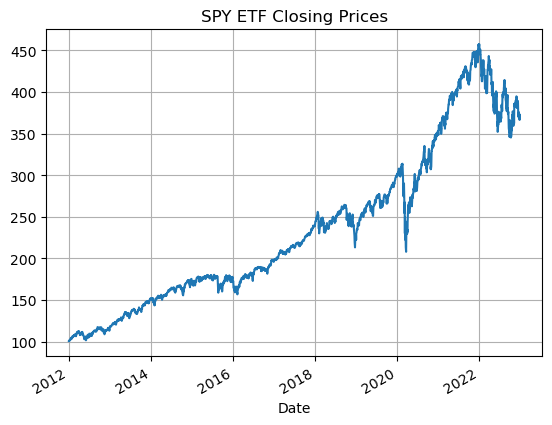

In [15]:
equity.plot()
plt.title("SPY ETF Closing Prices")
plt.grid()

The equity ETF sees an almost continuous rise in its prices except for a sharp dip in early 2020, which coincides with the first wave of the covid pandemic. There is also a dip in 2022.

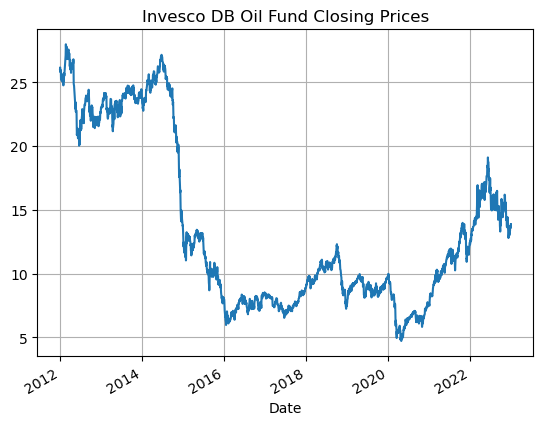

In [17]:
crude_oil.plot()
plt.title("Invesco DB Oil Fund Closing Prices")
plt.grid()

The Invesco Crude Oil ETF sees the sharp fall in the mid 2010s and then sees movement within a range for the remainder of the time period under consideration.

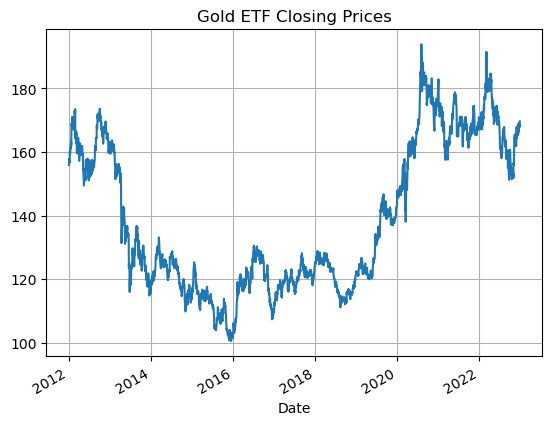

In [19]:
gold.plot()
plt.title("Gold ETF Closing Prices")
plt.grid()

The Gold ETF sees a dip in the early 2010s, then stays flat before rising starting in 2018.

Let us have a look at the skew and the kurtosis of all 3 ETFs

In [22]:
print("The skew and kurtosis in the Equity ETF data is {0} and {1} respectively".format(equity.skew(), equity.kurtosis()))
print("The skew and kurtosis in the Oil ETF data is {0} and {1} respectively".format(crude_oil.skew(), crude_oil.kurtosis()))
print("The skew and kurtosis in the Gold ETF data is {0} and {1} respectively".format(gold.skew(), gold.kurtosis()))

The skew and kurtosis in the Equity ETF data is 0.6422238459295742 and -0.6606505621810301 respectively
The skew and kurtosis in the Oil ETF data is 0.738444853967293 and -0.9998038458374703 respectively
The skew and kurtosis in the Gold ETF data is 0.39954065132761857 and -1.3152042787043552 respectively


Now, let us check for the stationarity of each series individually

In [24]:
#First, the Equity ETF
adf_result_equity = adfuller(equity)
adf_statistic = adf_result_equity[0] 
p_value = adf_result_equity[1]
used_lags = adf_result_equity[2] 
critical_values = adf_result_equity[4] 

adf_statistic, p_value, used_lags, critical_values

(-0.5905017553131152,
 0.873113829504488,
 27,
 {'1%': -3.43273884556851,
  '5%': -2.8625954199228967,
  '10%': -2.567331834008205})

In [25]:
#Second, the Oil ETF
adf_result_crude_oil = adfuller(crude_oil)
adf_statistic = adf_result_crude_oil[0] 
p_value = adf_result_crude_oil[1]
used_lags = adf_result_crude_oil[2] 
critical_values = adf_result_crude_oil[4] 

adf_statistic, p_value, used_lags, critical_values

(-1.8839062586074542,
 0.33966957560755373,
 1,
 {'1%': -3.432716369874773,
  '5%': -2.8625854938408413,
  '10%': -2.5673265493658404})

In [26]:
#Finally, the Gold ETF
adf_result_gold = adfuller(gold)
adf_statistic = adf_result_gold[0] 
p_value = adf_result_gold[1]
used_lags = adf_result_gold[2] 
critical_values = adf_result_gold[4] 

adf_statistic, p_value, used_lags, critical_values

(-1.3375143748927665,
 0.6118395523429857,
 0,
 {'1%': -3.4327155138680454,
  '5%': -2.8625851157957265,
  '10%': -2.5673263480950106})

None of the three series are stationary. For all the three series, the ADF statistic is larger than the critical values and the p-value is greater than 0.05. 

Let us check for the persistence of each time series

In [29]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(equity.autocorr(lag = i))

0.9995227178674256
0.9978916484020698
0.9959237319554236
0.9836716054602321
0.9724906289875292
0.9362630910259381
0.9241349592264114
0.9391750716256282


In [30]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(gold.autocorr(lag = i))

0.998293142192759
0.9915596896491187
0.9842318017766246
0.9303872797771524
0.8664537468422341
0.7330396037892724
0.20605224282567552
-0.4259101875055885


In [31]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(crude_oil.autocorr(lag = i))

0.9993631661788525
0.997084307228448
0.9939891284387814
0.9575816133052568
0.9071803294961714
0.7864044487808172
0.3065435218141149
-0.28815222149534864


There appears to be considerable autocorrelation in all the three time series.

Let us plot the histrograms for all three series

Text(0.5, 1.0, 'Distribution of Closing Prices of the SPY ETF')

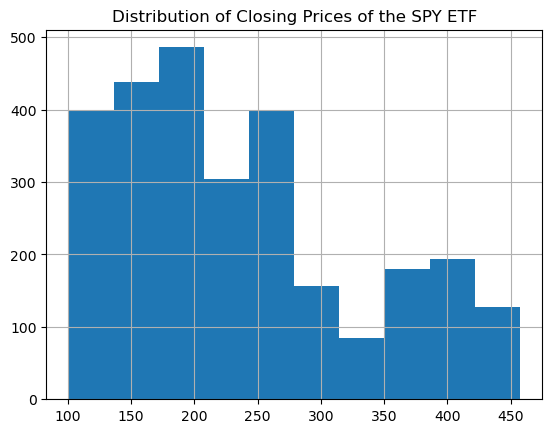

In [34]:
equity.hist()
plt.title("Distribution of Closing Prices of the SPY ETF")

Text(0.5, 1.0, 'Distribution of Closing Prices of the oil ETF')

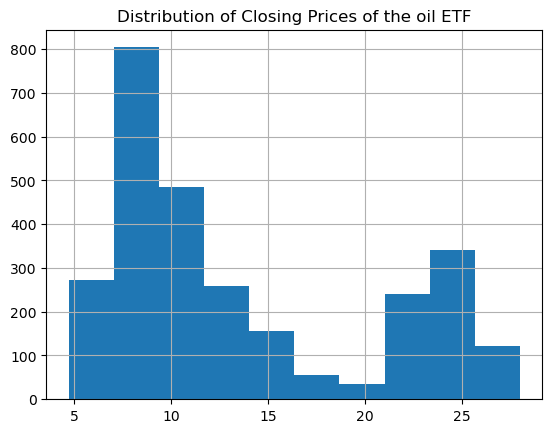

In [35]:
crude_oil.hist()
plt.title("Distribution of Closing Prices of the oil ETF")

Text(0.5, 1.0, 'Distribution of Closing Prices of the Gold ETF')

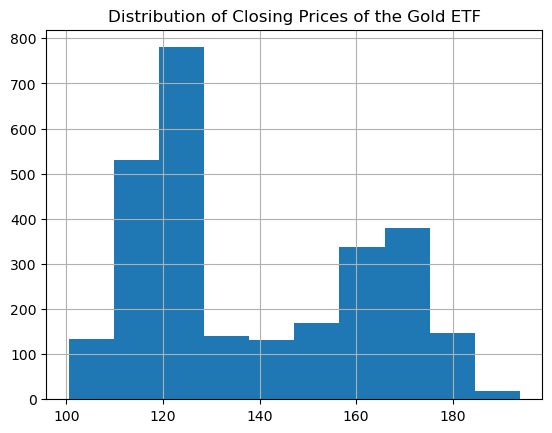

In [36]:
gold.hist()
plt.title("Distribution of Closing Prices of the Gold ETF")

Now, let us look at the scatterplots and the correlations of the series pairwise

In [38]:
gold.corr(equity)

0.5351892525658719

In [39]:
gold.corr(crude_oil)

0.13426845218926117

In [40]:
equity.corr(crude_oil)

-0.4507366085622942

The Equity and Crude Oil ETFs are negatively correlated with each other, meaning that one goes down while the other goes up. This may be explained by the fact that stock markets usually see a downturn when oil prices go up as the latter generally eats into company profits.
The correlation between the Crude Oil and Gold WTFs is a very mild 0.13. The Equity and gold ETFs on the other hand are moderately positively correlated.

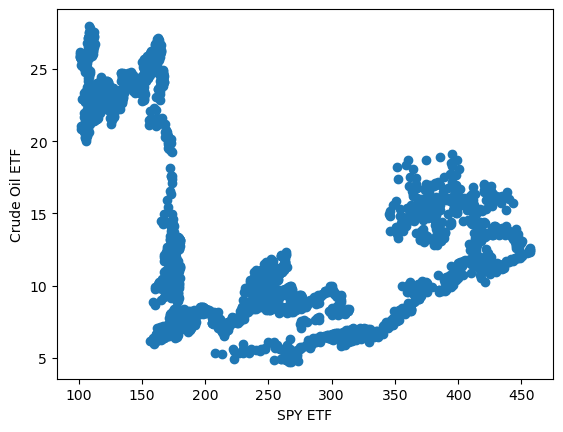

In [42]:
plt.scatter(equity, crude_oil)
plt.xlabel("SPY ETF")
plt.ylabel("Crude Oil ETF");

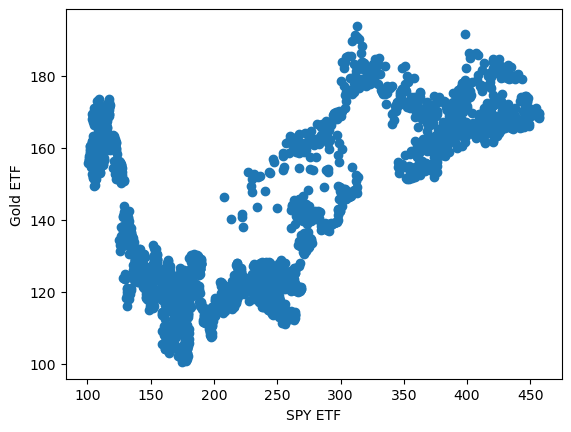

In [43]:
plt.scatter(equity, gold)
plt.xlabel("SPY ETF")
plt.ylabel("Gold ETF");

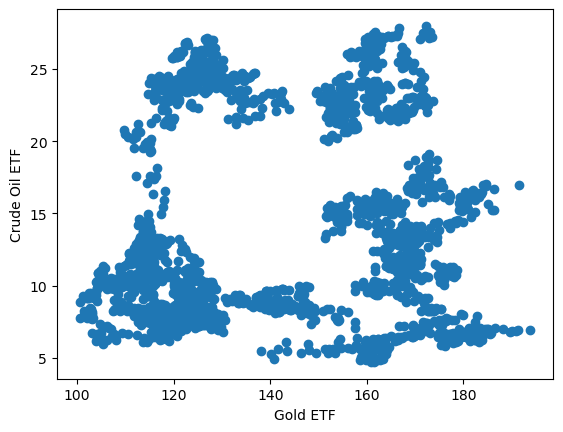

In [44]:
plt.scatter(gold, crude_oil)
plt.xlabel("Gold ETF")
plt.ylabel("Crude Oil ETF");

## Step 2

Let us now build the LSTM model separately for each time series

First, we try model-building using just the vanilla time series

In [214]:
equity_data = equity.to_frame()

In [216]:
equity_data.tail()

,Close
Date,
2022-12-23 00:00:00-05:00,372.400543
2022-12-27 00:00:00-05:00,370.931946
2022-12-28 00:00:00-05:00,366.322021
2022-12-29 00:00:00-05:00,372.916016
2022-12-30 00:00:00-05:00,371.933655


We define the train, test and validation samples

In [219]:
val_split = 0.15
train_set = equity_data[equity_data.index < "2018-01-01"] #data until the end of 2017
test_set = equity_data[equity_data.index > "2018-01-01"] #data from 2018 to 20222

train_split = len(train_set)/len(equity_data)
test_split = len(test_set)/len(equity_data)
train_size = int(len(equity_data) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(equity_data) - train_size)
print("Train-test split:", train_split, test_split)

Train-test split: 0.5451589595375722 0.45484104046242774


In [221]:
len(equity_data[equity_data.index > "2018-01-01"])

1259

In [223]:
equity_data.head()

,Close
Date,
2012-01-03 00:00:00-05:00,100.752853
2012-01-04 00:00:00-05:00,100.910873
2012-01-05 00:00:00-05:00,101.179550
2012-01-06 00:00:00-05:00,100.918808
2012-01-09 00:00:00-05:00,101.163795


In [225]:
window_size = 25

In [227]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

In [229]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i, 0])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i, 0])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [231]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

Now, let us build a basic LSTM model

In [234]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [236]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))

In [238]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                       │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,609 (4.35 MB)

 Trainable params: 1,140,609 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [240]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 17s - 870ms/step - loss: 0.2464 - val_loss: 0.0223
Epoch 2/100
20/20 - 5s - 225ms/step - loss: 0.0693 - val_loss: 0.1218
Epoch 3/100
20/20 - 5s - 226ms/step - loss: 0.0331 - val_loss: 0.0148
Epoch 4/100
20/20 - 5s - 225ms/step - loss: 0.0229 - val_loss: 0.0184
Epoch 5/100
20/20 - 5s - 228ms/step - loss: 0.0218 - val_loss: 0.0185
Epoch 6/100
20/20 - 5s - 231ms/step - loss: 0.0212 - val_loss: 0.0247
Epoch 7/100
20/20 - 5s - 230ms/step - loss: 0.0216 - val_loss: 0.0162
Epoch 8/100
20/20 - 5s - 229ms/step - loss: 0.0211 - val_loss: 0.0192


Let us now test the predictions of this model on the training data

In [253]:
train_pred = model.predict(X_train)
print("r2 score of the model on the in-sample set:", r2_score(y_train, train_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_train, train_pred.flatten()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
r2 score of the model on the training set: 0.9848859671744947
correlation between the predicted values and the actual in-sample data: [[1.         0.99378978]
 [0.99378978 1.        ]]


In [257]:
y_pred = model.predict(X_test)
print("r2 score of the model on the out-of-sample test set:", r2_score(y_test, y_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_test, y_pred.flatten()))

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
r2 score of the model on the out-of-sample test set: 0.9498353649623535
correlation between the predicted values and the actual in-sample data: [[1.         0.97725707]
 [0.97725707 1.        ]]


In [259]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

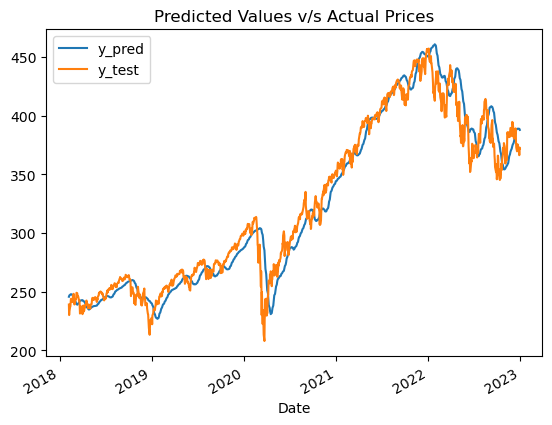

In [261]:
equity_pred = pd.DataFrame()
equity_pred["y_pred"] = (pd.DataFrame(y_pred))
equity_pred["y_test"] = pd.DataFrame(y_test)
equity_pred.index = equity_data[train_size+26:].index
equity_pred.plot()
plt.title("Predicted Values v/s Actual Prices");

Modeling the Crude Oil ETF

In [265]:
crude_oil_data = crude_oil.to_frame()

In [267]:
train_set = crude_oil_data[crude_oil_data.index < "2018-01-01"] #data until the end of 2017
test_set = crude_oil_data[crude_oil_data.index > "2018-01-01"] #data from 2018 to 2022

In [269]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

In [271]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i, 0])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i, 0])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [273]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

Model Building

In [276]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [278]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(1))

In [280]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 711,553 (2.71 MB)

 Trainable params: 711,553 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

In [282]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=15, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 13s - 658ms/step - loss: 0.3660 - val_loss: 0.1205
Epoch 2/100
20/20 - 3s - 148ms/step - loss: 0.1023 - val_loss: 0.1063
Epoch 3/100
20/20 - 3s - 150ms/step - loss: 0.0539 - val_loss: 0.0125
Epoch 4/100
20/20 - 3s - 152ms/step - loss: 0.0366 - val_loss: 0.0128
Epoch 5/100
20/20 - 3s - 154ms/step - loss: 0.0333 - val_loss: 0.0121
Epoch 6/100
20/20 - 3s - 158ms/step - loss: 0.0330 - val_loss: 0.0130
Epoch 7/100
20/20 - 3s - 148ms/step - loss: 0.0335 - val_loss: 0.0124
Epoch 8/100
20/20 - 3s - 150ms/step - loss: 0.0324 - val_loss: 0.0121
Epoch 9/100
20/20 - 3s - 151ms/step - loss: 0.0319 - val_loss: 0.0118
Epoch 10/100
20/20 - 3s - 154ms/step - loss: 0.0314 - val_loss: 0.0118
Epoch 11/100
20/20 - 3s - 148ms/step - loss: 0.0314 - val_loss: 0.0118
Epoch 12/100
20/20 - 3s - 149ms/step - loss: 0.0309 - val_loss: 0.0117
Epoch 13/100
20/20 - 3s - 150ms/step - loss: 0.0307 - val_loss: 0.0117
Epoch 14/100
20/20 - 3s - 150ms/step - loss: 0.0306 - val_loss: 0.0119
Epoch 15/100
2

In [284]:
train_pred = model.predict(X_train)
print("r2 score of the model on the in-sample set:", r2_score(y_train, train_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_train, train_pred.flatten()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
r2 score of the model on the in-sample set: 0.995935062444917
correlation between the predicted values and the actual in-sample data: [[1.         0.99807192]
 [0.99807192 1.        ]]


In [286]:
y_pred = model.predict(X_test)
print("r2 score of the model on the out-of-sample test set:", r2_score(y_test, y_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_test, y_pred.flatten()))

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
r2 score of the model on the out-of-sample test set: 0.978089376020763
correlation between the predicted values and the actual in-sample data: [[1.         0.98944929]
 [0.98944929 1.        ]]


In [288]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

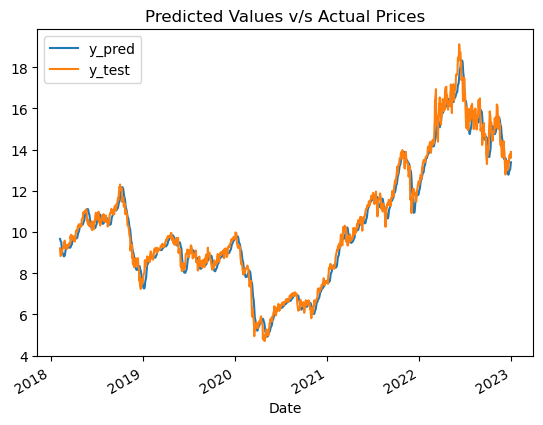

In [290]:
crude_oil_pred = pd.DataFrame()
crude_oil_pred["y_pred"] = pd.DataFrame(y_pred)
crude_oil_pred["y_test"] = pd.DataFrame(y_test)
crude_oil_pred.index = crude_oil_data[train_size+26:].index
crude_oil_pred.plot()
plt.title("Predicted Values v/s Actual Prices");

Modeling the prices of the Gold ETF

In [293]:
gold_data = gold.to_frame()

In [295]:
gold_data.tail()

,Close
Date,
2022-12-23 00:00:00-05:00,167.259995
2022-12-27 00:00:00-05:00,168.669998
2022-12-28 00:00:00-05:00,167.910004
2022-12-29 00:00:00-05:00,168.850006
2022-12-30 00:00:00-05:00,169.639999


In [296]:
train_set = gold_data[gold_data.index < "2018-01-01"] #data until the end of 2017
test_set = gold_data[gold_data.index > "2018-01-01"] #data from 2018 to 20222

In [299]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

In [301]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i, 0])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i, 0])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [303]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

In [305]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [307]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))

In [309]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                       │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,609 (4.35 MB)

 Trainable params: 1,140,609 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [310]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 17s - 846ms/step - loss: 0.2450 - val_loss: 0.1621
Epoch 2/100
20/20 - 5s - 228ms/step - loss: 0.0995 - val_loss: 0.0577
Epoch 3/100
20/20 - 5s - 228ms/step - loss: 0.0580 - val_loss: 0.0465
Epoch 4/100
20/20 - 5s - 234ms/step - loss: 0.0501 - val_loss: 0.0298
Epoch 5/100
20/20 - 5s - 232ms/step - loss: 0.0484 - val_loss: 0.0310
Epoch 6/100
20/20 - 5s - 226ms/step - loss: 0.0480 - val_loss: 0.0294
Epoch 7/100
20/20 - 5s - 225ms/step - loss: 0.0486 - val_loss: 0.0293
Epoch 8/100
20/20 - 5s - 227ms/step - loss: 0.0472 - val_loss: 0.0295
Epoch 9/100
20/20 - 5s - 226ms/step - loss: 0.0465 - val_loss: 0.0296
Epoch 10/100
20/20 - 5s - 226ms/step - loss: 0.0462 - val_loss: 0.0289
Epoch 11/100
20/20 - 4s - 225ms/step - loss: 0.0460 - val_loss: 0.0289
Epoch 12/100
20/20 - 5s - 229ms/step - loss: 0.0475 - val_loss: 0.0348
Epoch 13/100
20/20 - 5s - 234ms/step - loss: 0.0467 - val_loss: 0.0300
Epoch 14/100
20/20 - 5s - 227ms/step - loss: 0.0453 - val_loss: 0.0298
Epoch 15/100
2

In [315]:
train_pred = model.predict(X_train)
print("r2 score of the model on the in-sample set:", r2_score(y_train, train_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_train, train_pred.flatten()))

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
r2 score of the model on the in-sample set: 0.9471649184583492
correlation between the predicted values and the actual in-sample data: [[1.         0.97331753]
 [0.97331753 1.        ]]


In [316]:
y_pred = model.predict(X_test)
print("r2 score of the model on the out-of-sample test set:", r2_score(y_test, y_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_test, y_pred.flatten()))

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
r2 score of the model on the out-of-sample test set: 0.9527973232653493
correlation between the predicted values and the actual in-sample data: [[1.         0.97801478]
 [0.97801478 1.        ]]


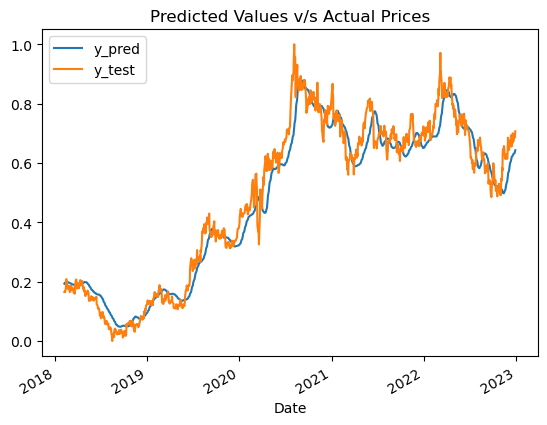

In [319]:
gold_pred = pd.DataFrame()
gold_pred["y_pred"] = pd.DataFrame(y_pred)
gold_pred["y_test"] = pd.DataFrame(y_test)
gold_pred.index = gold_data[train_size+26:].index
gold_pred.plot()
plt.title("Predicted Values v/s Actual Prices");

## Step 3

Now, for the multi-output DL Model

In [397]:
data = pd.DataFrame()
data["equity"] = equity
data["crude_oil"] = crude_oil
data["gold"] = gold

In [399]:
data

,equity,crude_oil,gold
Date,,,
2012-01-03 00:00:00-05:00,100.752853,26.042213,155.919998
2012-01-04 00:00:00-05:00,100.910873,26.165094,156.710007
2012-01-05 00:00:00-05:00,101.179550,25.814001,157.779999
2012-01-06 00:00:00-05:00,100.918808,25.919331,157.199997
2012-01-09 00:00:00-05:00,101.163795,25.831560,156.500000
...,...,...,...
2022-12-23 00:00:00-05:00,372.400543,13.693008,167.259995
2022-12-27 00:00:00-05:00,370.931946,13.793423,168.669998
2022-12-28 00:00:00-05:00,366.322021,13.647365,167.910004


In [401]:
train_set = data[equity_data.index < "2018-01-01"] #data until the end of 2017
test_set = data[equity_data.index > "2018-01-01"] #data from 2018 to 2022

In [403]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

In [405]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [407]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

In [409]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train.shape[1], 3),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [411]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(3))

In [413]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                       │ (None, 25, 128)             │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 25, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_41 (LSTM)                       │ (None, 25, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_42 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,600,963 (6.11 MB)

 Trainable params: 1,600,963 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [415]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 19s - 926ms/step - loss: 0.2739 - val_loss: 0.2930
Epoch 2/100
20/20 - 6s - 295ms/step - loss: 0.1392 - val_loss: 0.1400
Epoch 3/100
20/20 - 6s - 298ms/step - loss: 0.0780 - val_loss: 0.0821
Epoch 4/100
20/20 - 6s - 297ms/step - loss: 0.0455 - val_loss: 0.0359
Epoch 5/100
20/20 - 6s - 295ms/step - loss: 0.0379 - val_loss: 0.0471
Epoch 6/100
20/20 - 6s - 298ms/step - loss: 0.0351 - val_loss: 0.0399
Epoch 7/100
20/20 - 6s - 298ms/step - loss: 0.0346 - val_loss: 0.0361
Epoch 8/100
20/20 - 6s - 296ms/step - loss: 0.0342 - val_loss: 0.0373
Epoch 9/100
20/20 - 6s - 294ms/step - loss: 0.0347 - val_loss: 0.0352
Epoch 10/100
20/20 - 6s - 293ms/step - loss: 0.0340 - val_loss: 0.0375
Epoch 11/100
20/20 - 6s - 318ms/step - loss: 0.0331 - val_loss: 0.0288
Epoch 12/100
20/20 - 11s - 558ms/step - loss: 0.0337 - val_loss: 0.0403
Epoch 13/100
20/20 - 6s - 323ms/step - loss: 0.0329 - val_loss: 0.0412
Epoch 14/100
20/20 - 6s - 320ms/step - loss: 0.0337 - val_loss: 0.0343
Epoch 15/100


In [417]:
train_pred = model.predict(X_train)
print("r2 score of the model on the in-sample set on the equity ETF:", r2_score(y_train[0], train_pred[0]))
print("correlation between the predicted values and the actual in-sample data on the equity ETF:", np.corrcoef(y_train[0], train_pred[0]))
print("r2 score of the model on the in-sample set on the crude oil ETF:", r2_score(y_train[1], train_pred[1]))
print("correlation between the predicted values and the actual in-sample data on the crude oil ETF:", np.corrcoef(y_train[1], train_pred[1]))
print("r2 score of the model on the in-sample set on the gold ETF:", r2_score(y_train[2], train_pred[2]))
print("correlation between the predicted values and the actual in-sample data on the gold ETF:", np.corrcoef(y_train[2], train_pred[2]))

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step
r2 score of the model on the in-sample set on the equity ETF: 0.9579344754176998
correlation between the predicted values and the actual in-sample data on the equity ETF: [[1.         0.99273681]
 [0.99273681 1.        ]]
r2 score of the model on the in-sample set on the crude oil ETF: 0.9642494172154408
correlation between the predicted values and the actual in-sample data on the crude oil ETF: [[1.         0.99534079]
 [0.99534079 1.        ]]
r2 score of the model on the in-sample set on the gold ETF: 0.9745800659706446
correlation between the predicted values and the actual in-sample data on the gold ETF: [[1.         0.99651305]
 [0.99651305 1.        ]]


In [419]:
test_pred = model.predict(X_test)
print("r2 score of the model on the in-sample set on the equity ETF:", r2_score(y_test[0], test_pred[0]))
print("correlation between the predicted values and the actual in-sample data on the equity ETF:", np.corrcoef(y_test[0], test_pred[0]))
print("r2 score of the model on the in-sample set on the crude oil ETF:", r2_score(y_test[1], test_pred[1]))
print("correlation between the predicted values and the actual in-sample data on the crude oil ETF:", np.corrcoef(y_test[1], test_pred[1]))
print("r2 score of the model on the in-sample set on the gold ETF:", r2_score(y_test[2], test_pred[2]))
print("correlation between the predicted values and the actual in-sample data on the gold ETF:", np.corrcoef(y_test[2], test_pred[2]))

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
r2 score of the model on the in-sample set on the equity ETF: 0.39660422882849267
correlation between the predicted values and the actual in-sample data on the equity ETF: [[1.         0.96712545]
 [0.96712545 1.        ]]
r2 score of the model on the in-sample set on the crude oil ETF: 0.05322561502254164
correlation between the predicted values and the actual in-sample data on the crude oil ETF: [[1.         0.90559308]
 [0.90559308 1.        ]]
r2 score of the model on the in-sample set on the gold ETF: -0.17241417079782484
correlation between the predicted values and the actual in-sample data on the gold ETF: [[1.         0.91922552]
 [0.91922552 1.        ]]


In [421]:
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(test_pred)

In [423]:
multi_output_real_prices = pd.DataFrame(y_test)
multi_output_pred_prices = pd.DataFrame(y_pred)

In [425]:
multi_output_real_prices.columns = [["Equity ETF", "Crude Oil ETF", "Gold ETF"]]
multi_output_pred_prices.columns = [["Equity ETF", "Crude Oil ETF", "Gold ETF"]]
multi_output_real_prices.index = data[train_size+26:].index
multi_output_pred_prices.index = data[train_size+26:].index

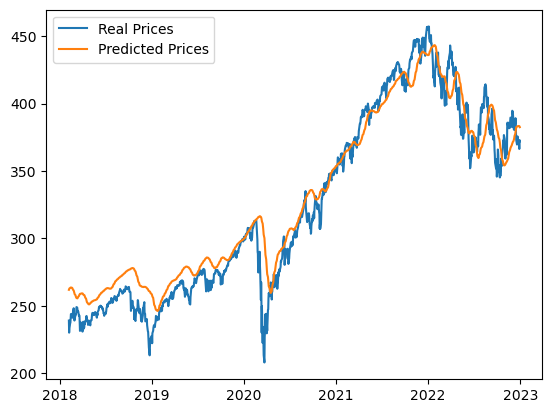

In [427]:
plt.plot(multi_output_real_prices["Equity ETF"])
plt.plot(multi_output_pred_prices["Equity ETF"])
plt.legend(["Real Prices", "Predicted Prices"])

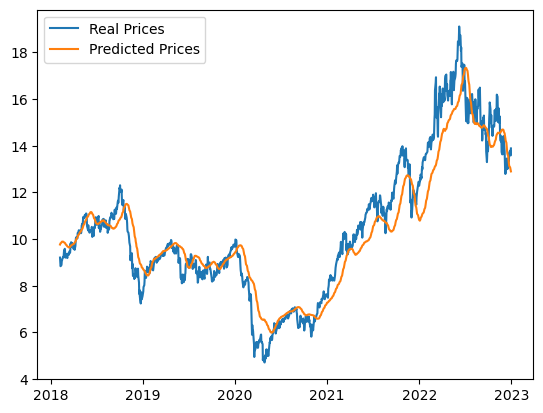

In [429]:
plt.plot(multi_output_real_prices["Crude Oil ETF"])
plt.plot(multi_output_pred_prices["Crude Oil ETF"])
plt.legend(["Real Prices", "Predicted Prices"])

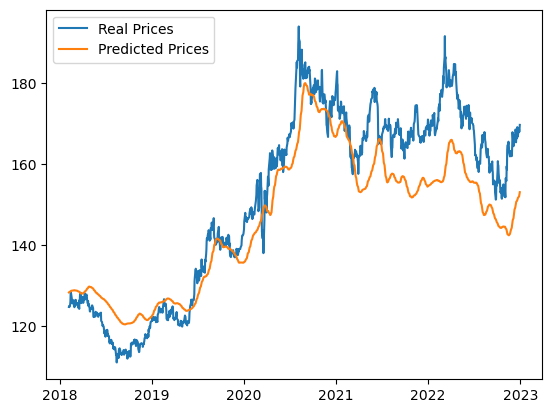

In [431]:
plt.plot(multi_output_real_prices["Gold ETF"])
plt.plot(multi_output_pred_prices["Gold ETF"])
plt.legend(["Real Prices", "Predicted Prices"])

In [172]:
real_25d_ret = multi_output_real_prices.pct_change(-25)
pred_25d_ret = multi_output_pred_prices.pct_change(-25)

In [173]:
real_25d_ret.dropna(inplace=True)
pred_25d_ret.dropna(inplace=True)

In [174]:
for i in range(0, pred_25d_ret.shape[0], 25):
    projected_returns = pred_25d_ret.iloc[i, :]
    print(projected_returns)

Equity ETF       0.023514
Crude Oil ETF    0.012404
Gold ETF        -0.000615
Name: 2018-02-07 00:00:00-05:00, dtype: float32
Equity ETF       0.017538
Crude Oil ETF   -0.050595
Gold ETF        -0.007606
Name: 2018-03-15 00:00:00-04:00, dtype: float32
Equity ETF      -0.00794
Crude Oil ETF   -0.07737
Gold ETF         0.00529
Name: 2018-04-20 00:00:00-04:00, dtype: float32
Equity ETF      -0.026207
Crude Oil ETF    0.031191
Gold ETF         0.015813
Name: 2018-05-25 00:00:00-04:00, dtype: float32
Equity ETF      -0.008215
Crude Oil ETF    0.011619
Gold ETF         0.024477
Name: 2018-07-02 00:00:00-04:00, dtype: float32
Equity ETF      -0.018252
Crude Oil ETF    0.046525
Gold ETF         0.023317
Name: 2018-08-07 00:00:00-04:00, dtype: float32
Equity ETF      -0.011384
Crude Oil ETF   -0.076697
Gold ETF        -0.004291
Name: 2018-09-12 00:00:00-04:00, dtype: float32
Equity ETF       0.050526
Crude Oil ETF    0.032449
Gold ETF        -0.017934
Name: 2018-10-17 00:00:00-04:00, dtype: flo